<h2> Load pretrained model from Github

In [1]:
!wget https://github.com/rlaze/Gym-Pong-demo/blob/master/saved_model.h5?raw=true
!mv 'saved_model.h5?raw=true' saved_model.h5
!ls

--2019-04-17 19:58:30--  https://github.com/rlaze/Gym-Pong-demo/blob/master/saved_model.h5?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rlaze/Gym-Pong-demo/raw/master/saved_model.h5 [following]
--2019-04-17 19:58:30--  https://github.com/rlaze/Gym-Pong-demo/raw/master/saved_model.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rlaze/Gym-Pong-demo/master/saved_model.h5 [following]
--2019-04-17 19:58:31--  https://raw.githubusercontent.com/rlaze/Gym-Pong-demo/master/saved_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent

<h2> Processing images and rewards

In [0]:
# functions used by Karpathy, see README for link

import numpy as np

# preprocessing
def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

# reward discount
def discount_rewards(r, gamma):
  """ take 1D float array of rewards and compute discounted reward """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  # we go from last reward to first one so we don't have to do exponentiations
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem
  return discounted_r

<h2> Make model

In [3]:
from keras.layers import Dense
from keras.models import Sequential

# initialize model
model = Sequential()

# hidden layer takes a pre-processed frame as input, and has 200 units
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

# output layer to determine action to take
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# load from git file
model.load_weights('saved_model.h5')

<h2> Setup Pong environment

In [0]:
import gym

# gym initialization
env = gym.make("Pong-v0")
observation = env.reset()
prev_input = None

# Macros
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

<h2> Train model

<h3> Stop training early by clicking the icon next to the cell

In [0]:
resume = True
running_reward = None
epochs_before_saving = 10 # change how often the model saves

while (True):

    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    reward_sum += reward
    
    # end of an episode
    if done:
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        
        # increment episode number
        episode_nb += 1
        
        # training
        model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
        
        # Saving the weights used by our model
        if episode_nb % epochs_before_saving == 0:    
            model.save_weights('saved_model_epoch' + str(episode_nb) + '.h5')
        
        # Log the reward
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        # Resetting
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()
        
        if(reward_sum > 9): # arbitrary stop point, or the model trains forever - still, very long train time
          break
        
        reward_sum = 0
        prev_input = None
        

<h2> View results as gif (downloads to computer)

In [0]:
# Frame list collector
frames = []
STEPS = 1000

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3

# initializing our environment
env = gym.make("Pong-v0")

# beginning of an episode
observation = env.reset()

In [0]:
# run test games - run above cell to clear previous frames
for i in range(STEPS):   
    
    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    #run one step
    observation, reward, done, info = env.step(action)
    frames.append(observation) # collecting observation

    # if episode is over, reset to beginning
    if done:
        observation = env.reset()
        frames.append(observation) # collecting observation

MovieWriter imagemagick unavailable. Trying to use pillow instead.


pong-model-1000-steps.gif  sample_data	saved_model.h5


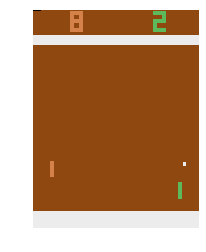

In [20]:
import matplotlib.pyplot as plt
from matplotlib import animation

def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')
        
# Save the run
save_frames_as_gif(frames, filename='pong-model-1000-steps.gif')
!ls

<h2> Download gif and final model weights



In [11]:
from google.colab import files

ask = input("Do you want to download model and gif? y for yes ")
if(ask == 'y'):
  files.download('pong-model-1000-steps.gif')
  model.save_weights('saved_model.h5')
  files.download('saved_model.h5')
  print('Downloaded!')

Do you want to download model and gif? y for yes y
Downloaded!
